In [1]:
import pandas as pd
structures = pd.read_csv('https://data.economie.gouv.fr/explore/dataset/coordonnees-des-structures-dgfip/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',sep=";")

# Variables disponibles

In [4]:
structures.columns

Index(['Nomenclature interne', 'TYPE DE SERVICE', 'LIBELLE DU SERVICE',
       'NOM DU SERVICE', 'DEPARTEMENT', 'ADRESSE', 'BP', 'CODE POSTAL',
       'COMMUNE', 'CODE COMMUNE', 'COURRIEL', 'HORAIRES 1', 'ACCUEIL SUR RDV',
       'geocodage', 'Type de démarche', 'TELEPHONE 1', 'TELEPHONE 2',
       'Nom Officiel Département', 'Code Officiel Région',
       'Nom Officiel Région', 'public', 'service', 'Code Courant Officiel',
       'Nom Officiel Commune', 'dep_code_de_geocodage'],
      dtype='object')

<AxesSubplot:>

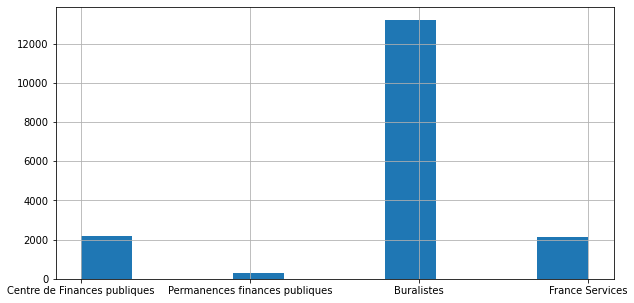

In [30]:
structures['TYPE DE SERVICE'].hist(figsize=(10,5))

In [50]:
structures['TYPE DE SERVICE'].unique()

array(['Centre de Finances publiques', 'Permanences finances publiques',
       'Buralistes', 'France Services'], dtype=object)

In [55]:
bret = structures[structures.public.str.contains('particuliers', na=False) & structures.DEPARTEMENT.str.slice(0,2).isin({'29','35','56'}) & (structures['TYPE DE SERVICE'] == "Centre de Finances publiques")]

In [68]:
from collections import Counter
ct = Counter()
for demarches in bret['Type de démarche']:
    ct.update(demarches.replace(">","").split('\n'))
ct.most_common()

[(' Effectuer une démarche,', 60),
 (' Obtenir un renseignement sur mes impôts et factures,', 58),
 (' Payer mes factures locales,', 43),
 ('(les questions portant sur le montant à payer relèvent des collectivités)',
  43),
 (' Payer mes impôts.', 17),
 (' Payer mes factures hospitalières', 5),
 ("(les questions portant sur le montant à payer relèvent de l'hôpital concerné)",
  5),
 (' Obtenir un renseignement sur les impôts de mon entreprise, sur mes impôts et factures',
  2),
 (' Effectuer une démarche', 2),
 (' Payer les impôts et taxes de mon entreprise ', 2)]